In [1]:
import numpy as np
np.random.seed(1337)

import warnings
warnings.filterwarnings("ignore")

import time as tm

import pandas as pd

from keras.models import Sequential, Model
from keras.constraints import maxnorm
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import medfilt

%matplotlib notebook

Using Theano backend.


## Load dataset

In [2]:
training_data = pd.read_csv('../data/training_data.csv')
blind_data = pd.read_csv('../data/nofacies_data.csv')

### Utilities function

In [3]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]])


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [4]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [5]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

## Extract data

In [6]:
X = training_data.drop(['Formation', 'Well Name', 'Depth', 'Facies', 'FaciesLabels'], axis=1).values
y = training_data['Facies'].values - 1

X_blind = blind_data.drop(['Formation', 'Well Name', 'Depth'], axis=1).values

wells = training_data["Well Name"].values

## Neural Network

In [7]:
def fDNN(in_dim, out_dim):
    # Model
    model = Sequential()
    model.add(Dense(210, input_dim=in_dim, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dense(out_dim, activation='softmax'))

    # Compilation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Validation with Leave One Well Out on Training Dataset

In [8]:
logo = LeaveOneGroupOut()

nb_classes = 9

t0 = tm.time()

In [9]:
f1s_ls = []
acc_ls = []
adj_ls = []

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    
    # Scaling
    scaler = preprocessing.RobustScaler().fit(X)
    X_tr = scaler.transform(X[train])
    X_te = scaler.transform(X[test])

    Y_tr = np_utils.to_categorical(y[train], nb_classes)

    in_dim = len(X_tr[0])

    # Method initialization
    mlp = fDNN(in_dim, nb_classes)
    
    # Training
    mlp.fit(X_tr, Y_tr, nb_epoch=10, batch_size=20, verbose=0) 
    
    # Predict
    y_hat = mlp.predict_classes(X_te, verbose=0)
    y_hat = medfilt(y_hat, kernel_size=7)
    
    try:
        f1s = f1_score(y[test], y_hat, average="weighted", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    except:
        f1s = 0

    try:
        conf = confusion_matrix(y[test], y_hat, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
        acc = accuracy(conf) # similar to f1 micro
    except:
        acc = 0

    try:
        acc_adj = accuracy_adjacent(conf, adjacent_facies)
    except:
        acc_adj = 0

    f1s_ls += [f1s]
    acc_ls += [acc]
    adj_ls += [acc_adj]
    print("{:>20s} f1_weigthted:{:.3f} | acc:{:.3f} | acc_adj:{:.3f}".format(well_name, f1s, acc, acc_adj))

t1 = tm.time()
print("Avg F1", np.average(f1s_ls)*100, "Avg Acc", np.average(acc_ls)*100, "Avg Adj", np.average(adj_ls)*100)
print((t1-t0), "seconds")

     CHURCHMAN BIBLE f1_weigthted:0.489 | acc:0.522 | acc_adj:0.854
      CROSS H CATTLE f1_weigthted:0.367 | acc:0.361 | acc_adj:0.870
            LUKE G U f1_weigthted:0.578 | acc:0.540 | acc_adj:0.922
               NEWBY f1_weigthted:0.494 | acc:0.501 | acc_adj:0.905
               NOLAN f1_weigthted:0.524 | acc:0.499 | acc_adj:0.863
          Recruit F9 f1_weigthted:0.667 | acc:0.500 | acc_adj:0.912
             SHANKLE f1_weigthted:0.646 | acc:0.639 | acc_adj:0.962
           SHRIMPLIN f1_weigthted:0.583 | acc:0.622 | acc_adj:0.943
Avg F1 54.3560133077 Avg Acc 52.3104852084 Avg Adj 90.3790615692
16.65639615058899 seconds


## Applying to Test Dataset

In [10]:
X_train = scaler.transform(X)
Y_train = np_utils.to_categorical(y, nb_classes)

mlp = fDNN(in_dim, nb_classes)

mlp.fit(X_train, Y_train, nb_epoch=10, batch_size=20, verbose=0)

In [11]:
x_blind = scaler.transform(X_blind)
y_blind = mlp.predict_classes(x_blind, verbose=0)
y_blind = medfilt(y_blind, kernel_size=7)
blind_data["Facies"] = y_blind + 1  # return the original value (1-9)

In [12]:
blind_data.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,2.0
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,2.0
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,2.0
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,2.0
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,2.0


In [13]:
blind_data.to_csv("PA_Team_Submission_0.csv")

<IPython.core.display.Javascript object>


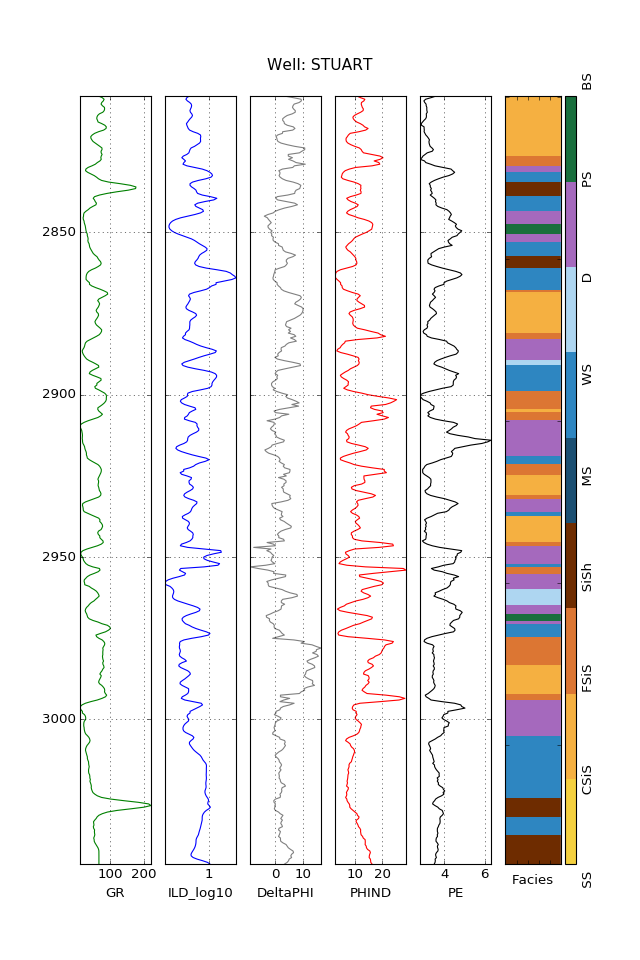

In [14]:
make_facies_log_plot(
    blind_data[blind_data['Well Name'] == 'STUART'],
    facies_colors)

<IPython.core.display.Javascript object>


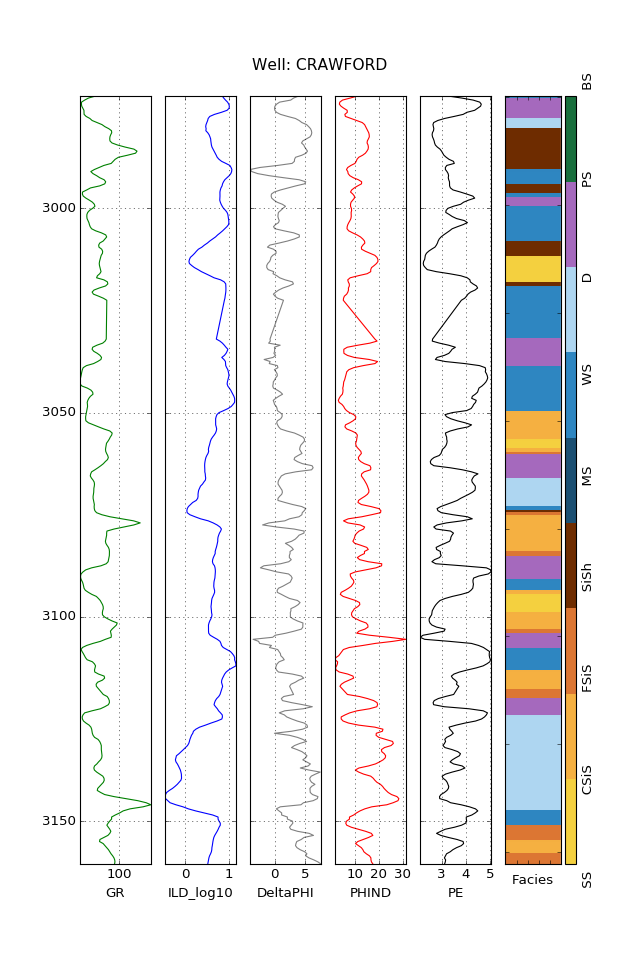

In [15]:
make_facies_log_plot(
    blind_data[blind_data['Well Name'] == 'CRAWFORD'],
    facies_colors)